## Contact Information

- **Name** - Mohd Muttalib
- **Phone** - +91-8445818187
- **Email** - muttalib1326@gmail.com
- **Kaggle** - https://www.kaggle.com/mohdmuttalib
- **GitHub** - https://github.com/MMuttalib1326

# Customer Reviews


## 1. Preparation
These are the packages we'll be using for this analysis:

In [ ]:
import random
from PIL import Image
from datetime import datetime
import unicodedata

import numpy as np
import pandas as pd
import nltk
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In order to easily spot 1 and 5 stars reviews through this analysis, I've picked red/blue diverging colors. This palette should be color blind safe.

In [ ]:
sns.set()

# A color blind safe palette that goes well with the background
COLOR_5S = '#0571b0'
COLOR_1S = '#ca0020'
REVIEWS_PALETTE = sns.color_palette((COLOR_1S, '#d57b6f', '#c6c6c6', '#7f9abc', COLOR_5S))

# Lighter background to help with review categories' colors
sns.set_style('darkgrid', {'axes.facecolor': '#eeeeee'})

# Default figure size
resize_plot = lambda: plt.gcf().set_size_inches(12, 5)

In [ ]:
orders = pd.read_csv('../input/brazilian-ecommerce/olist_orders_dataset.csv')
reviews = pd.read_csv('../input/brazilian-ecommerce/olist_order_reviews_dataset.csv')

# Convert columns to datetime
reviews['review_creation_date'] = pd.to_datetime(reviews['review_creation_date'], format='%Y/%m/%d %H:%M:%S')
reviews['review_answer_timestamp'] = pd.to_datetime(reviews['review_answer_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'], format='%Y/%m/%d %H:%M:%S')
orders['order_delivered_customer_date'] = pd.to_datetime(orders['order_delivered_customer_date'], format='%Y/%m/%d %H:%M:%S')

# Merge with orders
reviews = pd.merge(reviews, orders, on='order_id')

# Remove unused columns
to_drop = [
    'review_id',
    'order_id',
    'customer_id',
    'review_comment_title',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_estimated_delivery_date'
]
reviews.drop(columns=to_drop, inplace=True)

## 2. Initial Exploration
We have two datasets merged together, as seen below. Notice how comments are left blank on some reviews.

In [ ]:
reviews.head()

,review_score,review_comment_message,review_creation_date,review_answer_timestamp,order_status,order_purchase_timestamp,order_delivered_customer_date
0,4,NaN,2018-01-18,2018-01-18 21:46:59,delivered,2018-01-11 15:30:49,2018-01-17 18:42:41
1,5,NaN,2018-03-10,2018-03-11 03:05:13,delivered,2018-02-28 12:25:19,2018-03-09 23:17:20
2,5,NaN,2018-02-17,2018-02-18 14:36:24,delivered,2018-02-03 09:56:22,2018-02-16 17:28:48
3,5,Recebi bem antes do prazo estipulado.,2017-04-21,2017-04-21 22:02:06,delivered,2017-04-09 17:41:13,2017-04-20 09:08:35
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01,2018-03-02 10:26:53,delivered,2018-02-10 10:59:03,2018-02-28 16:33:35


There's 100K reviews on our dataframe, with an average of 4.1 stars.

In [ ]:
p_5s = len(reviews[reviews['review_score'] == 5]) * 100 / len(reviews)
p_1s = len(reviews[reviews['review_score'] == 1]) * 100 / len(reviews)
first_dt = reviews['review_creation_date'].min()
last_dt = reviews['review_creation_date'].max()
avg_s = reviews['review_score'].mean()
print(len(reviews), 'reviews')
print('First:', first_dt)
print('Last:', last_dt)
print(f'5★: {p_5s:.1f}%')
print(f'1★: {p_1s:.1f}%')
print(f'Average: {avg_s:.1f}★')

99224 reviews
First: 2016-10-02 00:00:00
Last: 2018-08-31 00:00:00
5★: 57.8%
1★: 11.5%
Average: 4.1★


Here we can see the review score distribution. It is interesting to observe that there's more 1 star reviews than 2/3 stars reviews.

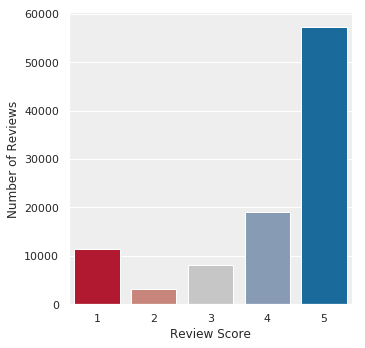

In [ ]:
 sns.catplot(
    x='review_score',
    kind='count',
    data=reviews,
    palette=REVIEWS_PALETTE
).set(
    xlabel='Review Score',
    ylabel='Number of Reviews',
);

We expect that reviews are created after the corresponding purchases, but our dataset has some negative values for the *review creation delay* (reviews sent to customers before the purchase happening?). Fortunately, most of them were sent to customers a few days later, as expected.

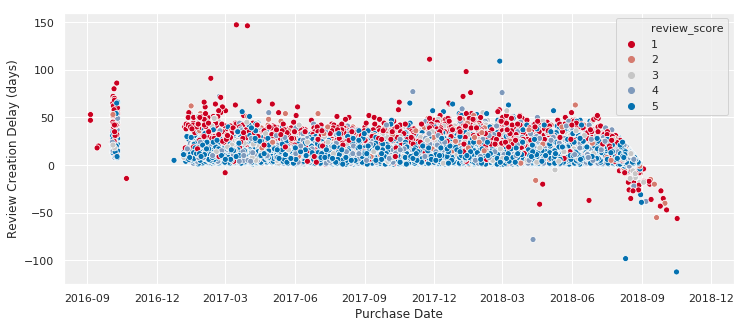

In [ ]:
reviews['review_creation_delay'] = (reviews['review_creation_date'] - reviews['order_purchase_timestamp']).dt.days
sns.scatterplot(
    x='order_purchase_timestamp',
    y='review_creation_delay',
    hue='review_score',
    palette= REVIEWS_PALETTE,
    data=reviews
).set(
    xlabel='Purchase Date',
    ylabel='Review Creation Delay (days)',
    xlim=(datetime(2016, 8, 1), datetime(2018, 12, 31))
);
resize_plot()

Here we group reviews by month using the  **order_purchase_timestamp** column and plot a timeseries. We will only consider reviews created after the purchase date here - otherwise we could get some weird patterns on our graph.

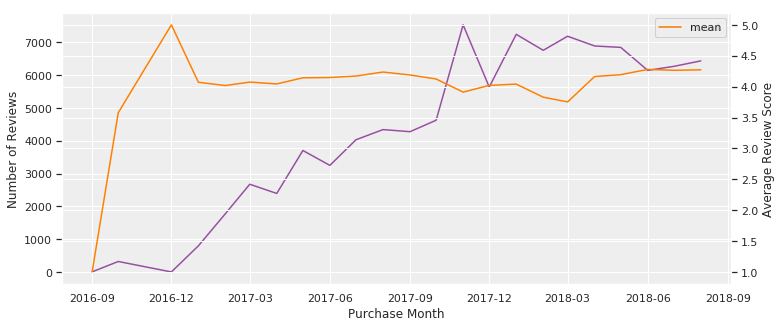

In [ ]:
reviews['year_month'] = reviews['order_purchase_timestamp'].dt.to_period('M')
reviews_timeseries = reviews[reviews['review_creation_delay'] > 0].groupby('year_month')['review_score'].agg(['count', 'mean'])

ax = sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(),
    y='count',
    data=reviews_timeseries,
    color='#984ea3',
    label='count'
)
ax.set(xlabel='Purchase Month', ylabel='Number of Reviews')

sns.lineplot(
    x=reviews_timeseries.index.to_timestamp(),
    y='mean',
    data=reviews_timeseries,
    ax=ax.twinx(),
    color='#ff7f00',
    label='mean'
).set(ylabel='Average Review Score');
resize_plot()

Next we investigate reviews by checking their order status:

In [ ]:
reviews.groupby('order_status')['order_status'].count()

order_status
approved           2
canceled         609
created            3
delivered      96361
invoiced         313
processing       296
shipped         1043
unavailable      597
Name: order_status, dtype: int64

If we plot the review score distribution of orders that do not have a *'delivered'* status, we can see that most of them have a 1 star rating.

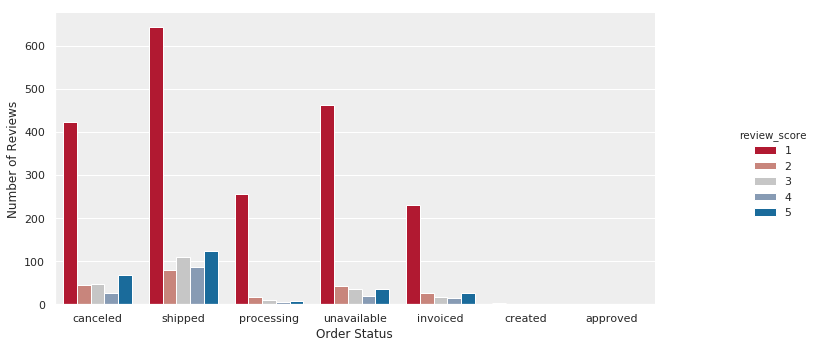

In [ ]:
ax = sns.catplot(
    x='order_status',
    kind='count',
    hue='review_score',
    data=reviews[reviews['order_status'] != 'delivered'],
    palette=REVIEWS_PALETTE
).set(xlabel='Order Status', ylabel='Number of Reviews');
resize_plot()

But how late do customers respond to Olist's satisfaction survey? We can check the difference between the **review_answer_timestamp** and **review_creation_date** columns.

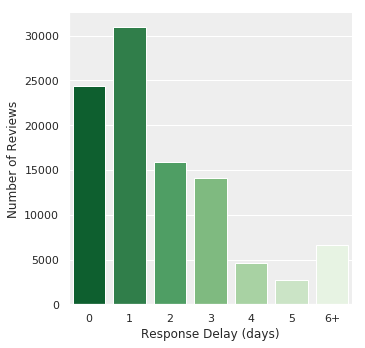

In [ ]:
reviews['delay'] = (reviews['review_answer_timestamp'] - reviews['review_creation_date']).dt.days

bins = [-1, 0, 1, 2, 3, 4, 5, 99999]
labels = ['0', '1', '2', '3', '4', '5', '6+']
reviews['delay_group'] = pd.cut(reviews['delay'], bins, labels=labels)

sns.catplot(
    x='delay_group',
    kind='count',
    data=reviews,
    palette=sns.color_palette('Greens_r', n_colors=7)
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');

We can see that while most customers wait a day before responding, unhappy customers (1 star reviews) are more likely to answer it in the same day.

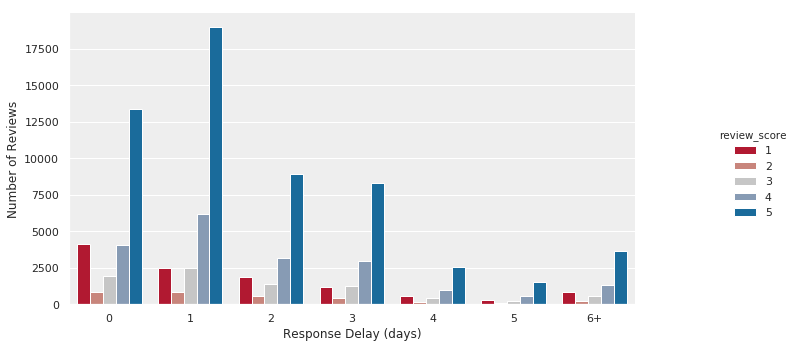

In [ ]:
sns.catplot(
    x='delay_group',
    kind='count',
    hue='review_score',
    data=reviews,
    palette=REVIEWS_PALETTE
).set(xlabel='Response Delay (days)', ylabel='Number of Reviews');
resize_plot()

## 3. Exploring Review Comments
Although we explored review ratings, we still know little about what customers like and dislike the most about Olist's experience.

We'll start by calculating the length of **review_comment_message**:

In [ ]:
reviews['review_length'] = reviews['review_comment_message'].str.len()
reviews[['review_score', 'review_length', 'review_comment_message']].head()

,review_score,review_length,review_comment_message
0,4,NaN,NaN
1,5,NaN,NaN
2,5,NaN,NaN
3,5,37.0,Recebi bem antes do prazo estipulado.
4,5,100.0,Parabéns lojas lannister adorei comprar pela I...


We can define *comment rate* as the number of non-NaN comments by the number of reviews.

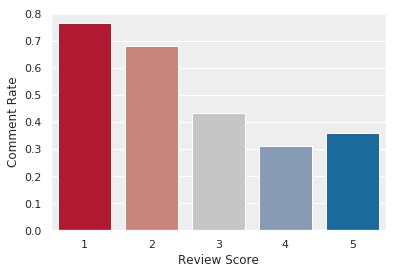

In [ ]:
def comment_rate(df):
    return df['review_length'].count() / len(df)

comment_rates = reviews.groupby('review_score').apply(comment_rate)
sns.barplot(
    comment_rates.index,
    comment_rates.values,
    palette=REVIEWS_PALETTE
).set(xlabel='Review Score', ylabel='Comment Rate');

It looks like unhappy customers are more likely to write comments. Below we can see that they write longer comments:

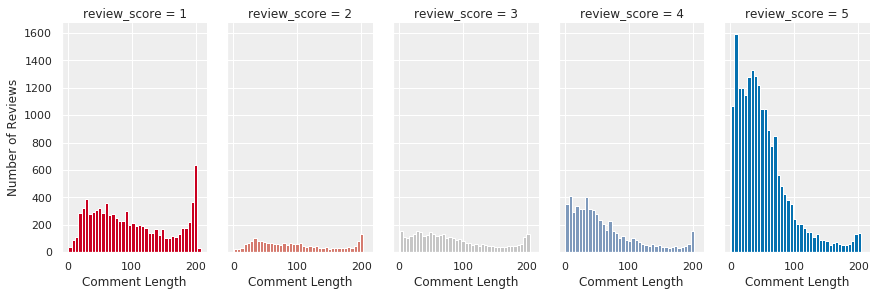

In [ ]:
g = sns.FacetGrid(data=reviews, col='review_score', hue='review_score', palette=REVIEWS_PALETTE)
g.map(plt.hist, 'review_length', bins=40)
g.set_xlabels('Comment Length')
g.set_ylabels('Number of Reviews')
plt.gcf().set_size_inches(12, 5)

But what are those comments about? We can use a bit of Natural Language Processing to discover that. The process is summarized below:
1. Convert text to lowercase
2. Compatibility decomposition (decomposes ã into a~)
3. Encode to ascii ignoring errors (removes accents), reencoding again to utf8
4. Tokenization, to break a sentence into words
5. Removal of stop words and non-alpha strings (special characters and numbers)
6. ~~Lemmatization (transform into base or dictionary form of a word)~~*
7. N-grams creation (group lemmas next to each other, by comment)
8. Grouping n-grams of all comments together

\* Lemmatization is not available for Portuguese words with the NLTK package. I tried stemming, but it only made the result look uglier, without further grouping the words. Another approach would be to translate the text to English first, but I'll leave this alternative for a later time.

I've made some functions to make this easier:

In [ ]:
def remove_accents(text):
    return unicodedata.normalize('NFKD', text).encode('ascii', errors='ignore').decode('utf-8')

STOP_WORDS = set(remove_accents(w) for w in nltk.corpus.stopwords.words('portuguese'))
STOP_WORDS.remove('nao') # This word is key to understand delivery problems later


def comments_to_words(comment):
    lowered = comment.lower()
    normalized = remove_accents(lowered)
    tokens = nltk.tokenize.word_tokenize(normalized)
    words = tuple(t for t in tokens if t not in STOP_WORDS and t.isalpha())
    return words

def words_to_ngrams(words):
    unigrams, bigrams, trigrams = [], [], []
    for comment_words in words:
        unigrams.extend(comment_words)
        bigrams.extend(' '.join(bigram) for bigram in nltk.bigrams(comment_words))
        trigrams.extend(' '.join(trigram) for trigram in nltk.trigrams(comment_words))

    return unigrams, bigrams, trigrams

def plot_freq(tokens, color):
    resize_plot()
    nltk.FreqDist(tokens).plot(25, cumulative=False, color=color)

Now that we have a basic NLP stack, we can use it to analyze 1 star and 5 stars reviews:

In [ ]:
commented_reviews = reviews[reviews['review_comment_message'].notnull()].copy()
commented_reviews['review_comment_words'] = commented_reviews['review_comment_message'].apply(comments_to_words)

reviews_5s = commented_reviews[commented_reviews['review_score'] == 5]
reviews_1s = commented_reviews[commented_reviews['review_score'] == 1]

unigrams_5s, bigrams_5s, trigrams_5s = words_to_ngrams(reviews_5s['review_comment_words'])
unigrams_1s, bigrams_1s, trigrams_1s = words_to_ngrams(reviews_1s['review_comment_words'])

Below are the frequency distributions for 5 star n-grams. We can identify some key topics Olist's customers enjoy about their experience:
- Fast delivery ('chegou antes prazo', 'entrega rapida', 'entregue antes prazo', 'super rapida')
- High quality goods ('produto otima qualidade', 'otimo produto', 'produto excelente', 'produto boa qualidade')
- Good packaging ('bem embalado', 'produto chegou bem')

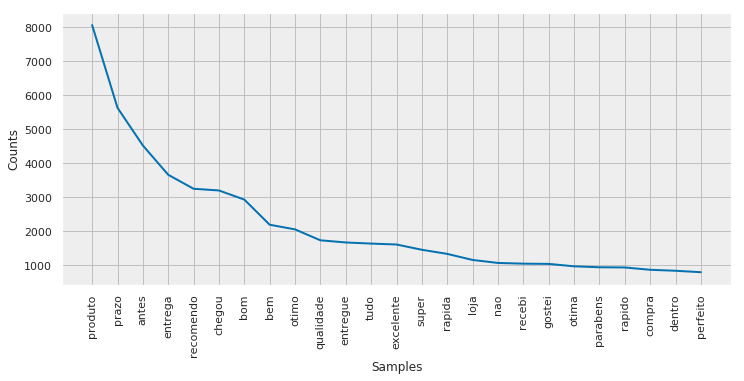

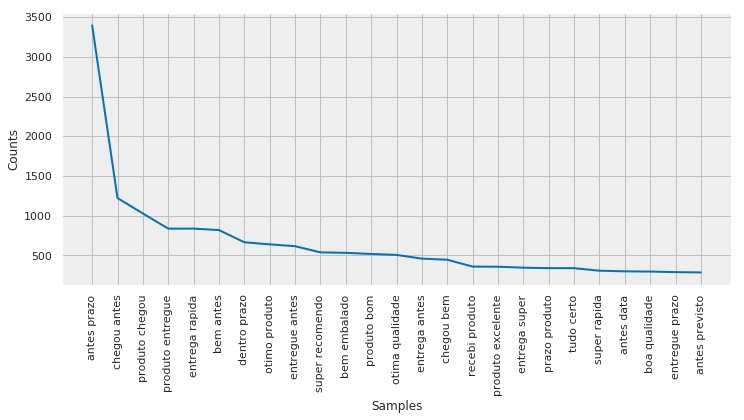

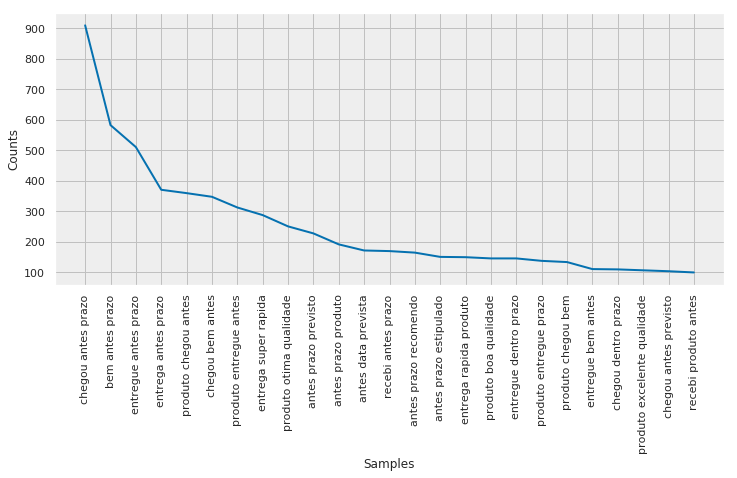

In [ ]:
plot_freq(unigrams_5s, COLOR_5S)
plot_freq(bigrams_5s, COLOR_5S)
plot_freq(trigrams_5s, COLOR_5S)

Below are the frequency distributions for 1 star n-grams. We can identify some key topics Olist's customers dislike about their experience:
- They didn't receive their goods yet ('recebi produto', 'ainda nao recebi', 'produto nao entregue', 'produto nao chegou', 'nao recebi mercadoria')
- They had some problem related with their invoices ('nota fiscal') \*
- They want refund ('quero dinheiro volta')
- Bad quality goods ('produto pessima qualidade', 'produto veio defeito')
- They had some problem when purchasing 2 products ('comprei dois produtos')
- Bad experience with the Lannister's shop ('lannister') \*
- Bad experience with customer service, probably ('contato') \*

\* It isn't clear yet how these topics are related to the 1 star ratings, so further analysis is done later

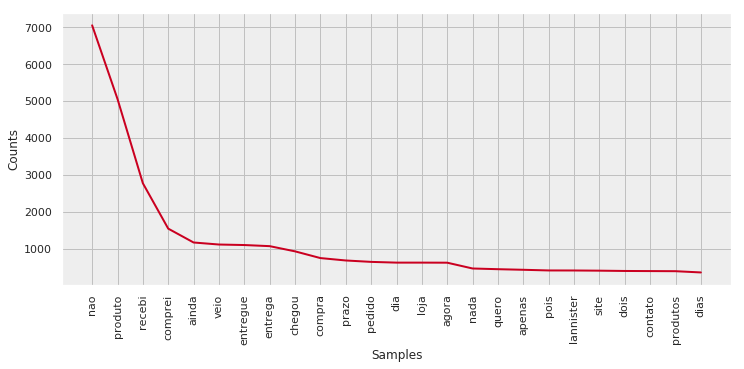

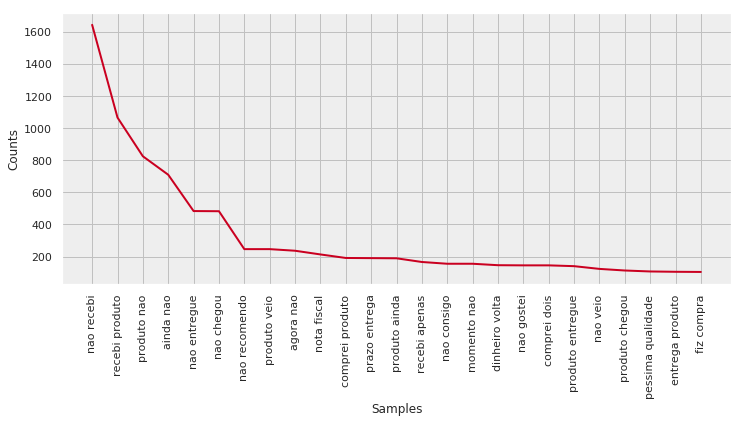

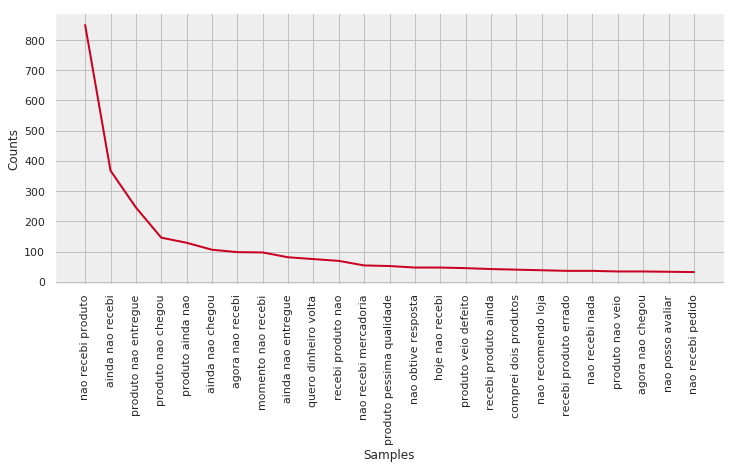

In [ ]:
plot_freq(unigrams_1s, COLOR_1S)
plot_freq(bigrams_1s, COLOR_1S)
plot_freq(trigrams_1s, COLOR_1S)

Since most 1 star reviews complain about the order not being delivered, we can select reviews that were created after the product was delivered. However, even when we do this, there are still some comments regarding delivery. We can observe n-grams similar to those above, with these new topics:
- They received the wrong goods ('recebi produto errado', 'produto veio errado', 'produto totalmente diferente')
- Fake goods ('produto nao original')

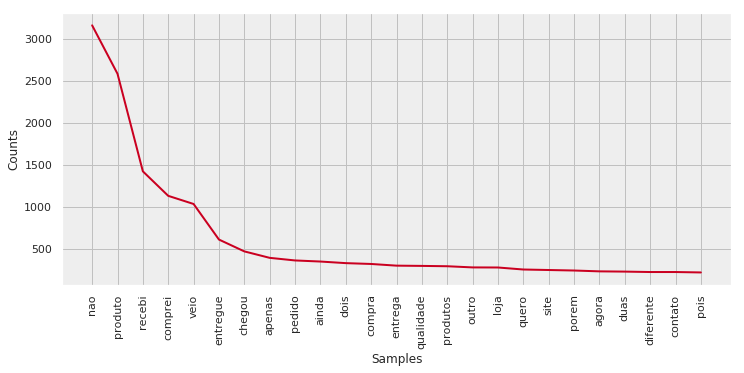

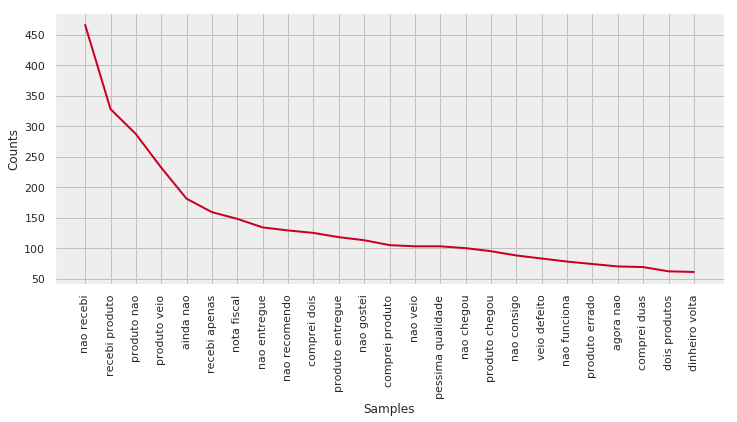

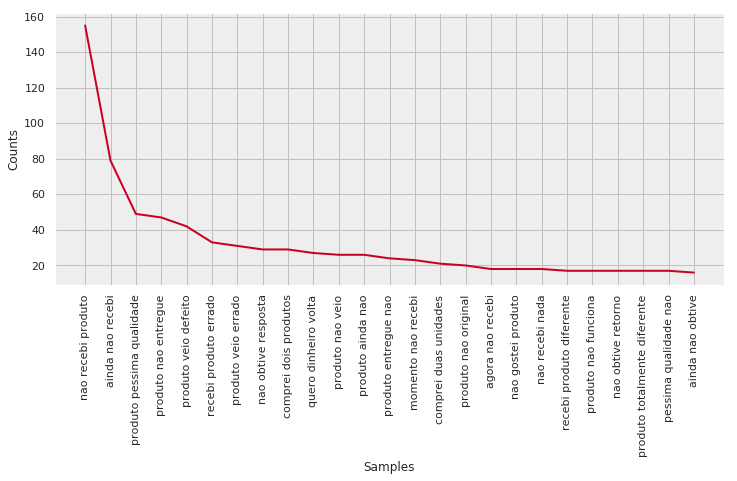

In [ ]:
reviews_delivered_1s = commented_reviews[(commented_reviews['review_score'] == 1) & (commented_reviews['order_delivered_customer_date'] < commented_reviews['review_creation_date'])]
unigrams_d1s, bigrams_d1s, trigrams_d1s = words_to_ngrams(reviews_delivered_1s['review_comment_words'])

plot_freq(unigrams_d1s, COLOR_1S)
plot_freq(bigrams_d1s, COLOR_1S)
plot_freq(trigrams_d1s, COLOR_1S)

We can further investigate some of these topics by analyzing the reviews that mention them. I've made a function below that shows some samples along their mean score.

In [ ]:
def search_words(df, words, n_samples=5, context_character_count=30):
    print(f'Search for "{words.upper()}"')
    words_set = set(words.split(' '))

    # Initial filter
    df = commented_reviews[commented_reviews['review_comment_words'].map(set) & words_set]

    if not len(df):
        print('> Number of reviews: 0\n')
        return

    # Filter by ordered words
    ordered_words_filter = lambda row, words: words in ' '.join(row['review_comment_words'])
    df = df[df.apply(ordered_words_filter, axis=1, args=(words,))]

    if len(df):
        print('> Number of reviews:', len(df))
    else:
        print('> Number of reviews: 0\n')
        return

    avg_rating = df['review_score'].mean()
    print(f'> Average rating: {avg_rating:.1f}★')

    if n_samples:
        print('> Samples:')
        first_word = words.split(' ')[0]
        for _, row in df.head(n_samples).iterrows():
            comment = row['review_comment_message'].replace('\r', '').replace('\n', '')
            score = row['review_score']
            normalized_comment = remove_accents(comment.lower())
            first_word_index = normalized_comment.index(first_word)

            i1 = first_word_index - context_character_count
            i2 = first_word_index + len(words) + context_character_count
            e1, e2 = '… ', ' …'

            if i1 < 0:
                i1 = 0
                e1 = ''

            if i2 > len(comment):
                i2 = len(comment)
                e2 = ''

            print(f'  {score}★', e1 + comment[i1:i2] + e2)
    print()

Now we can use this function to dig deeper. Assuming that you do not speak Portuguese, these are the conclusions I've made about them:
- Some people didn't receive their invoices
- Customers have mixed reviews about the Lannister's shop
- People rate seller's customer service badly, which seems to be unresponsive in some cases
- Some customers received fake items

In [ ]:
search_words(commented_reviews, 'nota fiscal')
search_words(commented_reviews, 'lannister')
search_words(commented_reviews, 'contato')
search_words(commented_reviews, 'original')

Search for "NOTA FISCAL"
> Number of reviews: 375
> Average rating: 2.1★
> Samples:
  1★ … uto desde antes da emissão da nota fiscal. Não fui avisada que estava n …
  1★ Nem fizeram a nota fiscal 
  5★ … Apesar da demora em expedir a nota fiscal, depois de expedida a entrega …
  4★ Não veio a nota fiscal
  3★ O produto veio sem nota fiscal, tive que solicitar pelo tele …

Search for "LANNISTER"
> Number of reviews: 1060
> Average rating: 3.1★
> Samples:
  5★ Parabéns lojas lannister adorei comprar pela Internet  …
  3★ … do solução por parte de Lojas lannister.
  3★ … ês após a compra. No site das lannister costumam chegar antes do praz …
  3★ … E. Quando tentei reclamar nas lannister o sistema estaav fora do ar.  …
  1★ … tes da entrega, liguei para a lannister e os atendentes não sabiam o  …

Search for "CONTATO"
> Number of reviews: 553
> Average rating: 1.6★
> Samples:
  1★ …  o produto, assim como nenhum contato por parte do .vendedor
  4★ … ra e a chegada do produto, só contato. 